## 03.Boosting계열
Boosting은 **여러 개의 약한 모델(Weak Learner 주로 얕은 결정 트리)** 을 **순차적으로 학습**시켜 **이전 모델의 오류를 보완**해나가는 **강한 예측기(Strong Predicter)** 를 사용하는 앙상블 기법이다.


- 약한 모델(예: 작은 깊이의 결정 트리)을 순차적으로 학습
- 이전 모델의 **오류(잔차)** 를 다음 모델이 보정(이전 모델이 틀린 샘플에 더 높은 가중치)
- 각 모델의 예측을 **가중합**하여 최종 예측을 수행
- 학습 방식: **순차적** / **오류 중심 개선**
- 사용 모델: 주로 **깊이가 얕은 결정 트리**
- 최적화 방식: **경사하강법(Gradient Descent)**


| 장점 | 단점 |
|------|------|
| 과적합에 비교적 강함 | 트리를 **순차적으로 학습**하여 속도가 느림 |
| 일반적으로 랜덤 포레스트보다 성능이 더 높음 | 병렬 처리 어려움 (순차 학습 구조) |




**Boosting 알고리즘 발전 단계**
- Boosting은 **오차 보정 방식의 순차적 학습 구조**로 앙상블을 구성
- **Gradient Boosting**은 경사하강법으로 트리를 추가하며 오차를 줄임
- **HistGradientBoosting**은 학습 속도와 메모리 효율성을 높인 개선된 버전 (노드분할 효율성을 위해 연속형 특성에 대한 binning 처리)






**손실 함수 및 학습 설정**


| 항목 | 설명 |
|------|------|
| **분류** | 로지스틱 손실 함수(log loss) 사용 |
| **회귀** | 평균제곱오차(MSE) 사용 |
| **학습률 (learning_rate)** | 한 번에 추가되는 트리의 영향력을 조절 |
| **subsample** | 훈련 세트 중 일부만 사용하면 확률적 경사하강법(SGD)처럼 작동 |


> ⚠ `subsample < 1.0` → **일부 데이터로 학습하여 일반화 성능 향상 가능**




**주요 알고리즘 및 클래스**


알고리즘 | 등장년도 | 핵심 특징
--- | --- | ---
AdaBoost | 1996 | 가중치를 이용해 오답 샘플을 강조
Gradient Boosting (GBM) | 1999 | 잔차(오차)를 줄이도록 새 모델 학습
XGBoost | 2014 | 정규화 + 병렬처리 최적화
LightGBM | 2017 | 히스토그램 기반 + Leaf-wise 트리
CatBoost | 2017 | 범주형 자동 처리 + 빠른 속도
HistGradientBoosting (scikit-learn) | 2019~ | LightGBM과 유사한 히스토그램 기반 구현






**히스토그램 기반 그레디언트 부스팅이란?**


히스토그램 기반 그레디언트 부스팅은 기존 GBM의 **느린 학습 속도** 문제를 개선한 방식이다.


- 연속 데이터를 **구간(binning)** 으로 나눠 계산량을 줄임
- 속도는 빠르면서도 일반 GBM에 가까운 예측 성능 유지
- 대용량 데이터 처리에 적합




In [17]:
from statistics import LinearRegression
from turtledemo.sorting_animate import disable_keys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier, \
    HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import root_mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

## 01. SimpleGradientBoostingClassifier  구현
- 잔차를 학습하는 GradientBoosting 분류기를 직접 구현

In [18]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
# 데이터 분리
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(X_train[:3])
print(y_train[:3])

(455, 30) (455,)
(114, 30) (114,)
[[1.032e+01 1.635e+01 6.531e+01 3.249e+02 9.434e-02 4.994e-02 1.012e-02
  5.495e-03 1.885e-01 6.201e-02 2.104e-01 9.670e-01 1.356e+00 1.297e+01
  7.086e-03 7.247e-03 1.012e-02 5.495e-03 1.560e-02 2.606e-03 1.125e+01
  2.177e+01 7.112e+01 3.849e+02 1.285e-01 8.842e-02 4.384e-02 2.381e-02
  2.681e-01 7.399e-02]
 [2.018e+01 1.954e+01 1.338e+02 1.250e+03 1.133e-01 1.489e-01 2.133e-01
  1.259e-01 1.724e-01 6.053e-02 4.331e-01 1.001e+00 3.008e+00 5.249e+01
  9.087e-03 2.715e-02 5.546e-02 1.910e-02 2.451e-02 4.005e-03 2.203e+01
  2.507e+01 1.460e+02 1.479e+03 1.665e-01 2.942e-01 5.308e-01 2.173e-01
  3.032e-01 8.075e-02]
 [1.066e+01 1.515e+01 6.749e+01 3.496e+02 8.792e-02 4.302e-02 0.000e+00
  0.000e+00 1.928e-01 5.975e-02 3.309e-01 1.925e+00 2.155e+00 2.198e+01
  8.713e-03 1.017e-02 0.000e+00 0.000e+00 3.265e-02 1.002e-03 1.154e+01
  1.920e+01 7.320e+01 4.083e+02 1.076e-01 6.791e-02 0.000e+00 0.000e+00
  2.710e-01 6.164e-02]]
[1 0 1]


In [19]:
# 이진 분류
 # - sigmoid(z) : 숫자값을 인자로 받아 확률값 반환
 # - log_odds(p) : 확률값을 인자로 받아 log(숫자값 z)로 반환

 # 초기값
y_pred  = np.mean(y_train)
print('y_pred', y_pred) # 양성클래스 확률값

# 로그오즈 계산 :  입력(p: 확률) -> 출력(z : 로그오즈)
log_odds = lambda p: np.log(p/(1-p))
z = log_odds(y_pred)
print('z=', z)

# 시그모이드 계산 : 입력 (z: 로그 오즈) -> 출력(p: 확률)
sigmoid = lambda z:1 / (1+np.exp(-z))
p = sigmoid(z)
print('p=', p)

y_pred 0.6263736263736264
z= 0.5166907432183888
p= 0.6263736263736264


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

class SimpleGradientBoostingClassifier:
    def __init__(self, n_estimators=100, lr=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.lr = lr
        self.max_depth = max_depth

        self.trees = [] # 약학습기를 관리할 리스트
        self._inital_log_odds = 0 #로그오즈 초기값

    def log_odds(self, p):
        """p(확률)을 입력 받아, z(로그오즈)를 반환하는 함수)"""
        return np.log(p/(1-p))


    def sigmoid(self, z):
        """z(로그오즈)을 입력 받아, p(확률)를 반환하는 함수)"""
        return 1/(1 + np.exp(-z))

    def fit(self, X, y):
        """모델 학습 함수"""
        #부스팅은 기존의 모델이랑 새로운것을 더해야하기 때문에 초기로그오즈값이 필요하다.

        # 초기 로그오즈값 설정 (y 평균값)
        y_mean = np.mean(y) # 확률값, 꼭 평균값일 필요는 없는데 손실을 최소화 해줘서 보통 사용한다.
        self.initial_log_odds = self.log_odds(y_mean) # 확률값 -> 로그오즈

        y_pred_log_odds = np.full_like(y, self.initial_log_odds, dtype = np.float64)
        #print('y_pred_log_odds', y_pred_log_odds)

        # 반복적으로 약학습기(회귀예측기)를 순차적으로 학습 : 이전 오차를 학습
        for _ in range(self.n_estimators):
            # 오차를 계산하기 위하여
            # 로그오즈값(z) -> 확률값(p) 변환 : 왜 ? 오차를 구하기 위해서
            y_pred_proba = self.sigmoid(y_pred_log_odds)
                                # 확률값변환 여기서

            # 잔차(오차) 계산
            residuals = y - y_pred_proba

            # 잔차에 대한 학습
            dt_reg = DecisionTreeRegressor(max_depth=self.max_depth)
            dt_reg.fit(X, residuals) # 이전 오차에 대한 것을 학습하기 때문에 -> 그러면 어떻게 되냐? 오차를 보고 얼마나 보정을 해야하는 지 알 수 있음


            # 현재 예측값으로 로그오즈값 갱신
            y_pred = dt_reg.predict(X) # 보정량 예측한 값
            y_pred_log_odds -= self.lr * y_pred # 보정량을 조금씩 쪼개서 적용시킨다.
                                # 잔차에 대해서 학습을 했으면 얼마나 보정해야할지 보정량이 나올 것이고
                                # 보정량을 몇 퍼센트 고정할 지 조금씩
            # 약학습기 관리
            self.trees.append(dt_reg) # 잔차가 계속 줄어드는 방식으로 반복된다.



    def predict_proba(self, X):
        """모델 예측을 위한 확률값 계산 함수"""

        # 초기 로그오즈 설정
        y_pred_log_odds = np.full((X.shape[0],), self.initial_log_odds,
                                  dtype = np.float64)

        # 학습된 약학습기의 예측 결과
        for tree in self.trees: # 잔차를 학습한 회귀 트리 반복
            y_pred_log_odds += self.lr * tree.predict(X) # 이미 잔차 방향으로 정해져있기 때문에 +를 해준다. (!= 위에서 fit 할 때 (오차 반대방향으로 간다. 손실을 줄이기 위해서))

        # 로그오즈값을 확률값으로 변환해서 반환
        return self.sigmoid(y_pred_log_odds) # 양성클래스의 확률값만 반환

    def predict(self, X):
        """모델 예측 함수"""
        return (self.predict_proba(X) >= 0.5).astype(int)


sgb_clf = SimpleGradientBoostingClassifier()
sgb_clf.fit(X_train, y_train)


# 평가
y_pred = sgb_clf.predict(X_train)
print("Train Accuracy :", accuracy_score(y_train, y_pred))


y_pred = sgb_clf.predict(X_test)
print("Test Accuracy :", accuracy_score(y_test, y_pred))

Train Accuracy : 0.9736263736263736
Test Accuracy : 0.9385964912280702


In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

class SimpleGradientBoostingClassifier :

    def __init__(self, n_estimators=100, lr=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.lr = lr
        self.max_depth = max_depth

        self.trees = [] # 약학습기를 관리할 리스트
        self.initial_log_odds = 0 # 로그오즈 초기값

    def log_odds(self, p):
        """ p(확률)을 입력 받아, z(로그오즈)를 반환하는 함수 """
        return np.log(p / (1 - p))

    def sigmoid(self, z):
        """ z(로그오즈)을 입력 받아, p(확률)를 반환하는 함수 """
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """ 모델 학습 함수 """

        # 초기 로그오즈값 설정 (y 평균값)
        y_mean = np.mean(y) # 확률값

        self.initial_log_odds = self.log_odds(y_mean) # 확률값 -> 로그오즈

        y_pred_log_odds = np.full_like(y, self.initial_log_odds, dtype=np.float64)
        # print('y_pred_log_odds = ', y_pred_log_odds)

        # 반복적으로 약학습기(회귀예측기)를 순차적으로 학습 : 이전 오차를 학습
        for _ in range(self.n_estimators):

            # 오차를 계산하기 위하여
            # 로그오즈값(z) -> 확률값(p) 변환
            y_pred_proba = self.sigmoid(y_pred_log_odds)

            # 잔차(오차) 계산 : (정답 - 예측확률)
            residuals = y - y_pred_proba
            #         = 1 - 0.3 => 0.7   -> p가 너무 낮으니 "z(로그오즈)를 올려서" p를 더 키워야 한다
            #         = 0 - 0.3 => -0.3  -> p가 너무 높으니 "z(로그오즈)를 내려서" p를 더 줄여야 한다


            # 잔차(보정량) 학습: X가 들어왔을 때 residual(= z를 얼마나/어느 방향으로 움직일지)을 예측하도록 학습
            dt_reg = DecisionTreeRegressor(max_depth=self.max_depth)
            dt_reg.fit(X, residuals) # -> 입력 X가 들어왔을 때 residual 값(보정량)이 얼마가 나와야 하는지 학습

            # 현재 예측값으로 로그오즈값 갱신
            y_pred = dt_reg.predict(X) # 보정량 예측한 값 (+면 z증가 -> p증가, -면 z감소 -> p감소)
            y_pred_log_odds += self.lr * y_pred

            # 약학습기 관리
            self.trees.append(dt_reg)

    def predict_proba(self, X):
        """ 모델 예측을 위한 확률값 계산 함수 """

        # 초기 로그오즈 설정
        y_pred_log_odds = np.full( (X.shape[0],), self.initial_log_odds, dtype=np.float64 )

        # 학습된 약학습기의 예측 결과
        for tree in self.trees:
            y_pred_log_odds += self.lr * tree.predict(X)

        # 로그오즈값을 확률값으로 변환해서 반환
        return self.sigmoid(y_pred_log_odds) # 양성클래스 확률값만 반환

    def predict(self, X):
        """ 모델 예측 함수 """
        return (self.predict_proba(X) >= 0.5).astype(int)

sgb_clf = SimpleGradientBoostingClassifier()
sgb_clf.fit(X_train, y_train)

# 평가
y_pred = sgb_clf.predict(X_train)
print("Train Accuracy : ", accuracy_score(y_train, y_pred))

y_pred = sgb_clf.predict(X_test)
print("Test Accuracy : ", accuracy_score(y_test, y_pred))


Train Accuracy :  0.9934065934065934
Test Accuracy :  0.9298245614035088


# 02. GradientBoostingClassifier

In [22]:
# 이진 분류 : 유방암 진단
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=42, max_depth=3)
gb_clf.fit(X_train, y_train)

y_pred = gb_clf.predict(X_train)
print("Train Accuracy :", accuracy_score(y_train, y_pred))

y_pred = gb_clf.predict(X_test)
print("Test Accuracy :", accuracy_score(y_test, y_pred))

Train Accuracy : 1.0
Test Accuracy : 0.956140350877193


In [23]:
# 다중분류
from sklearn.datasets import load_wine


wine = load_wine()
X, y = wine.data, wine.target

# 타겟 클래스 0 1 2
print(np.unique(y, return_counts=True))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(array([0, 1, 2]), array([59, 71, 48]))


In [24]:
# 모델 학습
gb_clf = GradientBoostingClassifier(random_state=42, max_depth=3)
gb_clf.fit(X_train, y_train)

# 모델 평가
y_pred = gb_clf.predict(X_train)
print("Train Accuracy :", accuracy_score(y_train, y_pred))
y_pred = gb_clf.predict(X_test)
print("Test Accuracy :", accuracy_score(y_test, y_pred))


# classification_report 클래스별 예측성능
print(classification_report(y_test, y_pred))

Train Accuracy : 1.0
Test Accuracy : 0.9074074074074074
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        19
           1       0.90      0.90      0.90        21
           2       1.00      0.79      0.88        14

    accuracy                           0.91        54
   macro avg       0.92      0.90      0.90        54
weighted avg       0.91      0.91      0.91        54



### 03.HistGradientBoostingClassifier


| 항목                     | 설명                                                                                               |
| ---------------------- |--------------------------------------------------------------------------------------------------|
| **모델 종류**              | `HistGradientBoostingClassifier` (분류)<br>`HistGradientBoostingRegressor` (회귀)                    |
| **핵심 개념**              | Gradient Boosting 기반의 앙상블 모델이며, **히스토그램 기반 분할 기법**으로 대규모 데이터 처리에 최적화됨                            |
| **피처 처리 방식**           | 연속형 특성을 **최대 256개 구간(bin)** 으로 구간화하여 분할 후보를 줄이고 속도 향상                                            |
| **결측치 처리**             | 자동 처리 (별도 전처리 불필요)                                                                               |
| **범주형 처리**             | **별도 인코딩 없이 직접 처리 가능**                                                                           |
| **성능 특징**              | - 기존 Gradient Boosting보다 **속도와 메모리 효율** 우수<br>- **수십만 개 이상**의 데이터에 적합<br>- **기본 설정만으로도 안정적인 성능** |
| **영향을 받은 모델**          | Microsoft의 LightGBM                                                                              |
| **Scikit-learn 정식 도입** | v1.0부터 experimental에서 정식 API로 변경됨                                                                |


**장점**


* 대규모 정형 데이터에 매우 빠르고 효율적
* 범주형과 결측치 처리를 자동으로 지원
* Early Stopping 등 과적합 방지 기능 내장


**주의사항**


* 앙상블 특성상 **개별 예측 해석 어려움**
* 과적합 가능성 존재 → 적절한 `regularization` 필요




**하이퍼 파라미터 (기존 GradientBoosting 클래스와 차이)**


<table border="1" cellspacing="0" cellpadding="5" style="border-collapse: collapse; width: 100%;">
 <thead>
   <tr style="background-color: #f2f2f2;">
     <th>공통 하이퍼파라미터</th>
     <th>설명</th>
   </tr>
 </thead>
 <tbody>
   <tr>
     <td>n_estimators</td>
     <td>부스팅 단계의 수 (기본값: 100)</td>
   </tr>
   <tr>
     <td>learning_rate</td>
     <td>학습률 (기본값: 0.1)</td>
   </tr>
   <tr>
     <td>max_depth</td>
     <td>각 트리의 최대 깊이</td>
   </tr>
   <tr>
     <td>min_samples_split</td>
     <td>내부 노드를 분할하기 위한 최소 샘플 수</td>
   </tr>
   <tr>
     <td>min_samples_leaf</td>
     <td>리프 노드에 있어야 하는 최소 샘플 수</td>
   </tr>
   <tr>
     <td>subsample</td>
     <td>각 단계에서 사용할 샘플의 비율</td>
   </tr>
   <tr>
     <td>loss</td>
     <td>손실 함수</td>
   </tr>
 </tbody>
 <thead>
   <tr style="background-color: #ffeb99;">
     <th>HistGradientBoosting 추가 하이퍼파라미터</th>
     <th>설명</th>
   </tr>
 </thead>
 <tbody>
   <tr style="background-color: #fff9e6;">
     <td>max_bins</td>
     <td>각 feature를 이산화할 때 사용할 최대 bin의 수 (기본값: 255)</td>
   </tr>
   <tr style="background-color: #fff9e6;">
     <td>max_leaf_nodes</td>
     <td>트리의 최대 리프 노드 수</td>
   </tr>
   <tr style="background-color: #fff9e6;">
     <td>l2_regularization</td>
     <td>모델의 복잡도를 제어하기 위한 L2 정규화 계수</td>
   </tr>
   <tr style="background-color: #fff9e6;">
     <td>early_stopping</td>
     <td>과적합을 방지하기 위해 조기 종료를 사용할지 여부</td>
   </tr>
   <tr style="background-color: #fff9e6;">
     <td>scoring</td>
     <td>조기 종료를 위한 평가지표 (예: 'loss', 'accuracy')</td>
   </tr>
 </tbody>
</table>


In [25]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(398, 30) (398,)
(171, 30) (171,)


In [26]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_clf = HistGradientBoostingClassifier(
    random_state=42,
    max_iter=5000, # 약학습기 개수(n_estimators 같은 역할)
    early_stopping=True,
    validation_fraction=0.2,# 20%를 검증용 데이터로 사용
    n_iter_no_change=10, # 진전이 없으면 조기 종료 해줘
    verbose=2 # 얘는 2번으로 해야 이터레이션마다 보여줌

)

results = cross_validate(hgb_clf, X_train, y_train, n_jobs= -1, return_train_score=True)
results_df = pd.DataFrame(results)
results_df

print('Train score: ', results_df['train_score'].mean())
print('Test score: ', results_df['test_score'].mean())
# 점수차이도 크지 않고 점수도 높고, 충분히 일반화가 됐다.
# 저거 5000번 다 돌은 게 아님, 10번 참았다가 진전이 없으면 멈춤


Train score:  0.9899469647680448
Test score:  0.957373417721519


In [27]:
# 직접 학습
hgb_clf.fit(X_train, y_train)

# 평가
print('Train Accuracy: ', accuracy_score(y_train, hgb_clf.predict(X_train)))
print('Test Accuracy:', accuracy_score(y_test, hgb_clf.predict(X_test)))

# val_loss : 검증용 점수 / 아까 0.2 쓴 거
# 점수가 0.11268보다 낮은게 10번 중에 안나와서 멈춘것!!!!!


Binning 0.000 GB of training data: 0.028 s
Binning 0.000 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
[1/5000] 1 tree, 7 leaves, max depth = 5, train loss: 0.57625, val loss: 0.59085, in 0.003s
[2/5000] 1 tree, 9 leaves, max depth = 5, train loss: 0.50937, val loss: 0.53483, in 0.003s
[3/5000] 1 tree, 14 leaves, max depth = 8, train loss: 0.45473, val loss: 0.48839, in 0.004s
[4/5000] 1 tree, 14 leaves, max depth = 8, train loss: 0.40868, val loss: 0.45073, in 0.003s
[5/5000] 1 tree, 15 leaves, max depth = 9, train loss: 0.36997, val loss: 0.41855, in 0.003s
[6/5000] 1 tree, 15 leaves, max depth = 9, train loss: 0.33656, val loss: 0.38540, in 0.003s
[7/5000] 1 tree, 14 leaves, max depth = 8, train loss: 0.30734, val loss: 0.36214, in 0.003s
[8/5000] 1 tree, 13 leaves, max depth = 6, train loss: 0.28166, val loss: 0.34064, in 0.003s
[9/5000] 1 tree, 13 leaves, max depth = 7, train loss: 0.25730, val loss: 0.31831, in 0.003s
[10/5000] 1 tree, 13 leaves, max depth = 8, 

#### permutation_importance
특성중요도를 확인하는 함수
특정 특성의 데이터를 열단위로 막 섞어서, 모델의 성능이 떨어지면 해당 특성의 중요도를 높이 평가

In [28]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(hgb_clf, X_test, y_test, random_state=42, n_jobs=-1, n_repeats=5) # n_jobs : 사용 가능한 모든 CPU 코어 사용
                        # n_repeats  : 특정 피처를 몇 번 섞어볼지

perm_importance_df = pd.DataFrame({
    'Feature' : cancer.feature_names,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

perm_importance_df

,Feature,Importance
23,worst area,5.263158e-02
1,mean texture,1.169591e-02
27,worst concave points,8.187135e-03
26,worst concavity,8.187135e-03
21,worst texture,8.187135e-03
4,mean smoothness,7.017544e-03
13,area error,7.017544e-03
25,worst compactness,5.847953e-03
24,worst smoothness,5.847953e-03
14,smoothness error,4.678363e-03


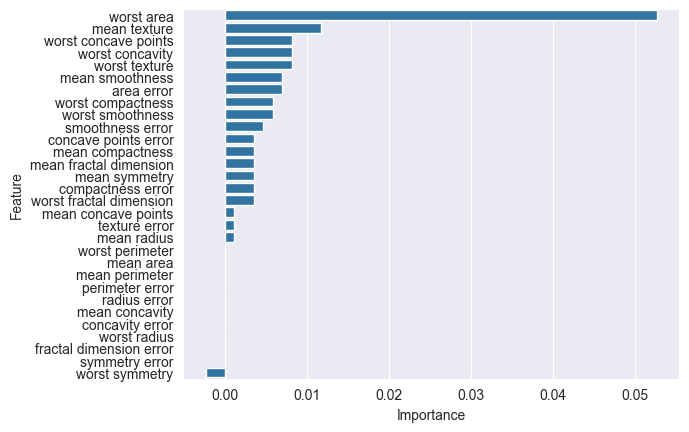

In [29]:
sns.barplot(perm_importance_df, x='Importance', y='Feature')
plt.show()

### 04.HistGradientBoostingRegressor

In [30]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(353, 10) (353,)
(89, 10) (89,)


In [31]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
hgb_reg = HistGradientBoostingRegressor(
    random_state=42,
    max_iter=5000,
    early_stopping=True,
    n_iter_no_change=50, # 검증점수가 50번 동안 나아지지 않으면 early_stopping 하겠다.
    validation_fraction=0.1,
    max_depth=1,
    min_samples_leaf=30,
    max_bins=255, #기본값 : 255
    l2_regularization=0.1, #기본값 : 0, 너무 크게 튀는 것을 막음
    learning_rate=0.1, #새로 만든 나무의 예측을 0.1 만큼만 반영하자
    verbose=2# 콘솔의 진행상황 출력해라
    )


hgb_reg.fit(X_train, y_train)
print('Train MSE :', mean_squared_error(y_train, hgb_reg.predict(X_train)))
print('Train R2 :', r2_score(y_train, hgb_reg.predict(X_train)))

print('Test MSE :', mean_squared_error(y_test, hgb_reg.predict(X_test)))
print('Test R2 :', r2_score(y_test, hgb_reg.predict(X_test)))


Binning 0.000 GB of training data: 0.017 s
Binning 0.000 GB of validation data: 0.000 s
Fitting gradient boosted rounds:
[1/5000] 1 tree, 2 leaves, max depth = 1, train loss: 2882.16205, val loss: 2830.32346, in 0.001s
[2/5000] 1 tree, 2 leaves, max depth = 1, train loss: 2732.33505, val loss: 2619.59995, in 0.002s
[3/5000] 1 tree, 2 leaves, max depth = 1, train loss: 2609.22436, val loss: 2495.90718, in 0.002s
[4/5000] 1 tree, 2 leaves, max depth = 1, train loss: 2494.58316, val loss: 2353.15278, in 0.002s
[5/5000] 1 tree, 2 leaves, max depth = 1, train loss: 2399.65925, val loss: 2209.30359, in 0.002s
[6/5000] 1 tree, 2 leaves, max depth = 1, train loss: 2313.14621, val loss: 2124.42788, in 0.002s
[7/5000] 1 tree, 2 leaves, max depth = 1, train loss: 2240.97576, val loss: 2030.96023, in 0.001s
[8/5000] 1 tree, 2 leaves, max depth = 1, train loss: 2175.07847, val loss: 1966.26267, in 0.002s
[9/5000] 1 tree, 2 leaves, max depth = 1, train loss: 2114.77551, val loss: 1940.08280, in 0.00